In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import yaml
import sys
import torch
import scipy.stats as stats
import math

ROOT = "../"
sys.path.insert(0,ROOT + "src/")
sys.path.insert(0,ROOT + "engine/")

from run_experiment import get_data

In [5]:
def load_experiment(exp_id,run):
    # get path
    path = ROOT + "mlruns/{}/{}/artifacts/".format(exp_id,run)
    # load model
    model = pd.read_pickle(path + "model.p")
    # load args
    args_filename = [v for v in os.listdir(path + "reproduce/engine/") if ".yml" in v][0]
    args_path = path + "reproduce/engine/" + args_filename
    with open(args_path,"r") as f:
        args = yaml.safe_load(f)
    return model,args

In [6]:
# set experiment
exp_id = "1"
run = "507f3be0445f4439b76446d3e2f8a6e7"

# load model
model,args = load_experiment(exp_id,run)
# get predictions
X,y = get_data(args)
output = model.predict_parameters(X)

In [7]:
def show_normal(mu,sigma,perc = .75,y_unit = 1000):
    # set x and y
    mu = mu_all[idx]
    sigma = sigma_all[idx]
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    y = stats.norm.pdf(x, mu, sigma)

    perc = .75
    start,end = stats.norm.interval(perc,mu,sigma)
    x_int = np.linspace(start,end, 100)
    y_int = stats.norm.pdf(x_int, mu, sigma)
    ticks = [start,mu,end]

    # plot
    with plt.style.context('dark_background'):
        fig = plt.figure(figsize = (12,6))
        plt.fill_between(x,y, color = "C0", alpha = .5)
        plt.fill_between(x_int,y_int, label = "75%", color = "C0", alpha=.8)
        density_mu = stats.norm.pdf(mu, mu, sigma)
        plt.text(mu,density_mu * .3,
                 "  {}%".format(int(100*perc)),
                 size = 40,
                 horizontalalignment='center',
                 color = "gray")
        plt.text(mu,density_mu*1.08,
                 "{:,}€".format(int((mu * y_unit))).replace(",","."),
                 size = 70,
                 horizontalalignment='center',
                 color = "C3")
        plt.xticks(ticks,["{:,}€".format(int((v * y_unit))).replace(",",".") for v in ticks],size=25)
        plt.yticks([])
        plt.ylim(0,density_mu*1.4)
        plt.xlim(mu - 3*sigma, mu + 3*sigma)
        plt.title("Salario netto annuale [stima]",size = 30)
        return fig

In [8]:
mu_all,sigma_all = output

for idx in np.random.choice(X.index,3):
    mu = mu_all[idx]
    sigma = sigma_all[idx]
    fig = show_normal(mu,sigma,.75, model.y_unit)
    fig.show()

/Users/davide/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  import sys
/Users/davide/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  import sys
/Users/davide/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  import sys


In [9]:
# check uncertainty estimate
perc = .75
start,end = stats.norm.interval(perc,mu_all,sigma_all)
((start < y/1000) & (y/1000 < end)).mean()

0.7877258235919234

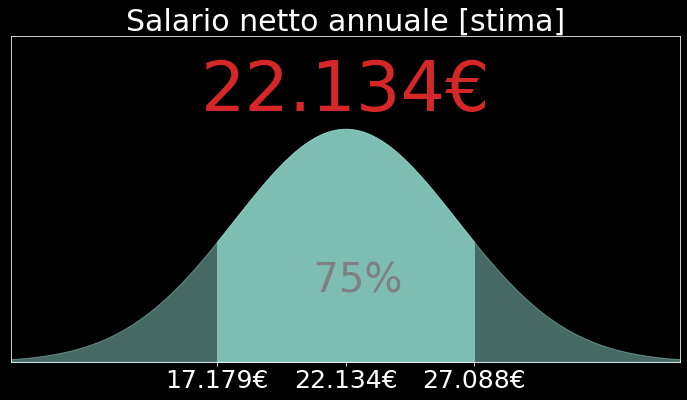

In [10]:
fig.savefig()

In [8]:
#X = pd.read_csv(ROOT + "data/preprocessed/bancaditalia/2016.csv")

In [9]:
catfeat_map = dict(
    partime = {"a tempo pieno": 1, "part-time": 2},
    contratto = {"a tempo indeterminato" : 1.0, "a tempo determinato" : 2.0, "di lavoro interinale" : 3.0, "non specificato" : None},
    dimensioni_azienda = {"fino a 4 addetti": 1, "tra 5 e 15 addetti": 2, "tra 16 e 19 addetti": 3, "tra 20 e 49 addetti": 4, "tra 50 e 99 addetti": 5, "tra 100 e 499 addetti": 6, "500 addetti ed oltre": 7, "Pubblica Amministrazione": 8, "non specificato":  None},
    titolo_studio = {"nessuno" : 1,"licenza elementare" : 2,"licenza media inferiore" : 3,"diploma professionale (3 anni)" : 4,"diploma media superiore" : 5,"diploma universitario/laurea triennale" : 6,"laurea/laurea magistrale" : 7,"specializzazione post-laurea" : 8},
    tipo_laurea = {"matematica, fisica, chimica, biologia, scienze, farmacia" : 1,"scienze agrarie e veterinaria" : 2,"medicina e odontoiatria" : 3,"ingegneria" : 4,"architettura e urbanistica" : 5,"economia e statistica" : 6,"scienze politiche, sociologia" : 7,"giurisprudenza" : 8,"lettere, filosofia, lingue, pedagogia, psicologia" : 9,"altro" : 10,"non laureato" : None,},
    tipo_diploma = {"istituto professionale" : 1,"istituto tecnico" : 2,"liceo (classico, scientifico e linguistico)" : 3,"liceo artistico e istituti d’arte" : 4,"magistrali" : 5,"altro" : 6,"non specificato" : None,},
    qualifica = {"operaio o posizione similare (inclusi salariati e apprendisti, lavoranti a domicilio, commessi)" : 1,"impiegato" : 2,"insegnante di qualunque tipo di scuola (inclusi incaricati, contrattisti e simili)" : 3,"impiegato direttivo/quadro" : 4,"dirigente, alto funzionario, preside, direttore didattico, docente universitario, magistrato" : 5,"altro" : 21,},
    settore = {"Agricoltura, silvicoltura e pesca" : 1, "Attività estrattive" : 2, "Attività manifatturiere" : 3, "Fornitura di energia elettrica, gas, vapore e aria condizionata" : 4, "Fornitura di acqua; reti fognarie, attività di trattamento dei rifiuti e risanamento" : 5, "Costruzioni" : 6, "Commercio all’ingrosso e al dettaglio; riparazioni di autoveicoli e motocicli" : 7, "Trasporto e magazzinaggio" : 8, "Servizi di alloggio e di ristorazione" : 9, "Servizi di informazione e comunicazione" : 10, "Attività finanziarie e assicurative" : 11, "Attività immobiliari" : 12, "Attività professionali, scientifiche e tecniche" : 13, "Attività amministrative e di servizi di supporto" : 14, "Amministrazione pubblica e difesa; assicurazione sociale obbligatoria" : 15, "Istruzione" : 16, "Sanità e assistenza sociale" : 17, "Attività artistiche, di intrattenimento e divertimento" : 18, "Altre attività di servizi" : 19, "Attività di famiglie e convivenze come datori di lavoro per personale domestico; produzione di beni e servizi indifferenziati per uso proprio da parte di famiglie e convivenze" : 20, "Attività di organizzazioni e organismi extraterritoriali" : 21, "non specificato" : None},
    regione = {"Piemonte" : 1,"Valle d'Aosta" : 2,"Lombardia" : 3,"Trentino" : 4,"Veneto" : 5,"Friuli" : 6,"Liguria" : 7,"Emilia Romagna" : 8,"Toscana" : 9,"Umbria" : 10,"Marche" : 11,"Lazio" : 12,"Abruzzo" : 13,"Molise" : 14,"Campania" : 15,"Puglia" : 16,"Basilicata" : 17,"Calabria" : 18,"Sicilia" : 19,"Sardegna" : 20,},
    ampiezza_comune = {"fino a 5.000 abitanti" : 1, "5.000-20.000 abitanti" : 2, "20.000-50.000 abitanti" : 3, "50.000-200.000 abitanti" : 4, "oltre 200.000 abitanti" : 5, }
)

In [2]:
import numpy as np
np.arange(70)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69])

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plr

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

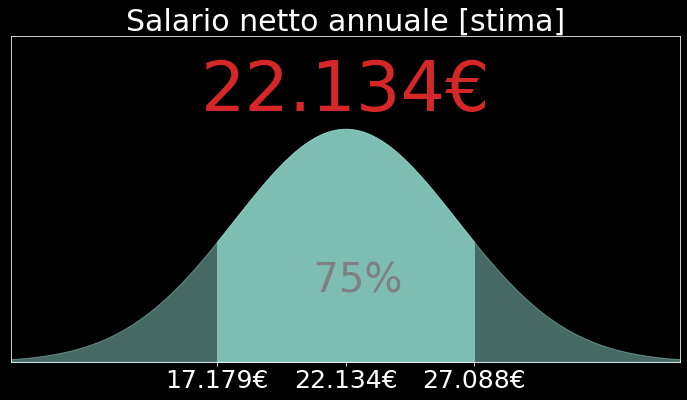

In [11]:
fig

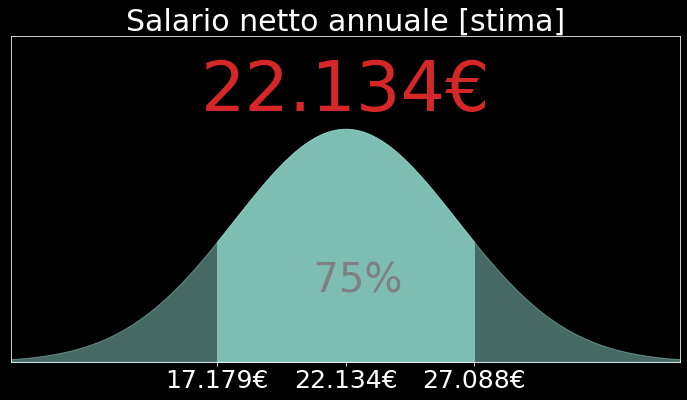

In [20]:
fig

In [24]:
plt.tight_layout()
fig.savefig("tmp",facecolor="black")

In [19]:
return StreamingResponse(io.BytesIO(im_png.tobytes()), media_type="image/png")